In [1]:
import pandas as pd
# pd.options.display.max_colwidth = 200

import numpy as np
from collections import defaultdict

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("white")

from pymystem3 import Mystem; mystem = Mystem()
from functools import lru_cache


from tqdm import tqdm
tqdm.pandas()

%matplotlib inline

# Data overview

In [3]:
data = pd.read_csv('./DATA_MANY_TOPICS.csv')

In [4]:
data.sample(5)

,index,text,title,topic,url
56839,56839,Суд признал фотографа Дмитрия Лошагина невинов...,Суд признал фотографа Лошагина невиновным в уб...,judiciary,https://lenta.ru/news/2014/12/25/loshagin/
175205,175224,"Игрок Team NP Кертис ""Aui_2000"" Линг подчеркну...","Кертис ""Aui_2000"" Линг: ""Следующий патч переве...",cybersport,http://www.sport-express.ru/cybersport/dota2/n...
132098,132100,Испанец Марсель Гранольерс и американец Джек С...,Гранольерс и Сок выиграли турнир в Базеле,tennis,http://www.sport-express.ru/tennis/atp/news/gr...
47483,47483,МВД уличило соратников кандидата в мэры Москвы...,МВД уличило соратников Навального в расхищении...,politics,https://lenta.ru/news/2013/08/19/checkcheck/
112619,112619,Россия поставляет оружие только легитимным вла...,Песков уточнил слова Путина о помощи сирийской...,politics,https://lenta.ru/news/2015/12/11/peskov1/


In [5]:
print('Number of news:', len(data))

Number of news: 188028


In [6]:
print('Number of topics:', data.topic.nunique())

Number of topics: 32


In [7]:
data.topic.value_counts()

football           31993
business           28022
politics           22849
forces             11492
hockey             11400
technologies        7097
films               6592
science             5558
crime               5308
internet            5067
realty              4878
basketball          4480
judiciary           4165
weapons             4120
music               3809
tennis              3571
auto                3453
companies           3316
cosmos              2732
boxing              2512
economics           2426
biathlon            2235
social-networks     2039
cybersport          1835
formula1            1433
animals             1225
books                939
religion             903
theatre              882
skiing               696
volleyball           528
chess                473
Name: topic, dtype: int64

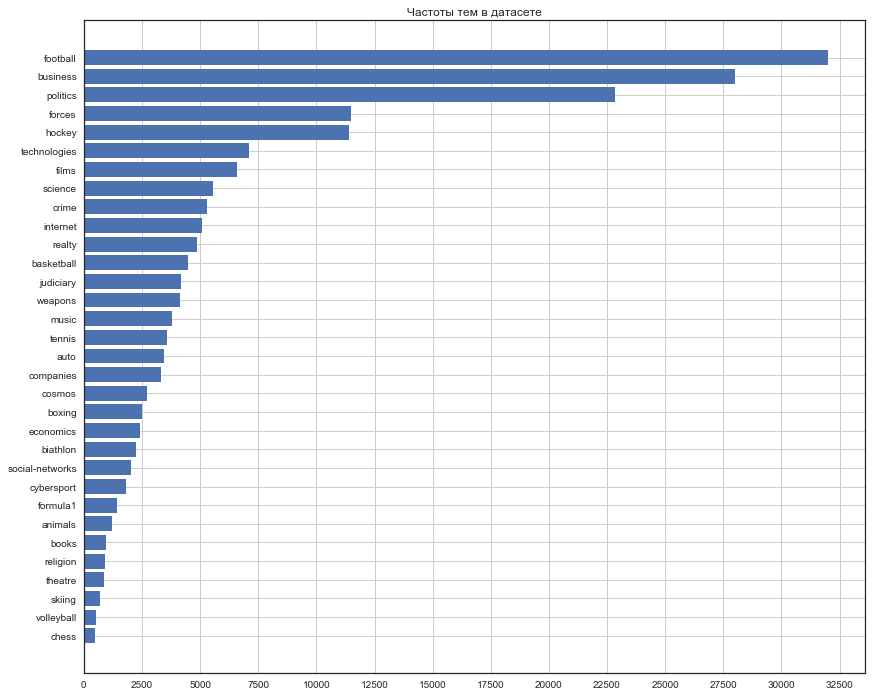

In [8]:
topics_freq = data.topic.value_counts(ascending=True)
plt.figure(figsize=(14,12))
plt.barh(range(len(topics_freq)), topics_freq.values)
plt.yticks(range(len(topics_freq)), topics_freq.index);
plt.xticks(np.arange(0, 33001, 2500));
plt.grid(True)
plt.title('Частоты тем в датасете');

In [9]:
class Pipeline(object):
    def __init__(self, *args):
        self.transformations = args
    def __call__(self, x):
        res = x
        for f in self.transformations:
            res = f(res)
        return res

In [10]:
from nltk.corpus import stopwords
from stop_words import get_stop_words
en_sw = get_stop_words('en')
ru_sw = get_stop_words('ru')
STOP_WORDS = set(en_sw) | set(ru_sw)
STOP_WORDS = STOP_WORDS | set(stopwords.words('russian')) | set(stopwords.words('english'))
STOP_WORDS = STOP_WORDS | set(['лента', 'новость', 'риа', 'тасс', 'редакция'])

def get_lower(text):
    return str(text).lower().strip()

def remove_punctuation(text):
    return ''.join([c if c.isalpha() or c in ['-',"'"] else ' ' for c in text])

@lru_cache(maxsize=None)
def get_word_normal_form(word):
    return ''.join(mystem.lemmatize(word)).strip().replace('ё', 'е').strip('-')

def lemmatize_words(text):
    res = []
    for word in text.split():
        norm_form = get_word_normal_form(word)
        if len(norm_form) > 2 and norm_form not in STOP_WORDS:
            res.append(norm_form)
    return ' '.join(res)

In [11]:
def remove_ria(text):
    prefix = text[:50]
    ria = 'РИА Новости'
    if ria in prefix:
        text = text[text.find(ria)+len(ria)+1:]
    return text

In [12]:
TEXT_PIPELINE = Pipeline(remove_ria, get_lower, remove_punctuation, lemmatize_words)

In [13]:
%%time
data.text = data.text.progress_apply(TEXT_PIPELINE)

100%|██████████| 188028/188028 [03:35<00:00, 873.59it/s] 


CPU times: user 2min 12s, sys: 17 s, total: 2min 29s
Wall time: 3min 36s


In [14]:
%%time
data.title = data.title.progress_apply(TEXT_PIPELINE)

100%|██████████| 188028/188028 [00:08<00:00, 21194.96it/s]


CPU times: user 7.31 s, sys: 417 ms, total: 7.72 s
Wall time: 8.91 s


In [15]:
vocabulary = defaultdict(int)
for news in data.itertuples():
    for word in news.text.split():
        vocabulary[word] += 1
print('Unique words in dataset:', len(vocabulary))

Unique words in dataset: 248197


In [16]:
n_min_occurance = 2
print('Number of words occured more than %d times: %d' % 
      (n_min_occurance, len(list(filter(lambda x: x[1] >= n_min_occurance, vocabulary.items())))))

Number of words occured more than 2 times: 145665


In [17]:
top_k = 25
print('Top %d most frequent words:' % top_k)
for i, (word, freq) in enumerate(sorted(vocabulary.items(), key=lambda x: -x[1])[:top_k]):
    print(i+1, word, freq)

Top 25 most frequent words:
1 россия 137518
2 компания 109728
3 сообщать 107408
4 свой 87352
5 российский 72945
6 становиться 65798
7 заявлять 65540
8 матч 64336
9 слово 62768
10 отмечать 56960
11 страна 52921
12 сша 52350
13 президент 51196
14 команда 50993
15 млрд 50716
16 получать 49254
17 новый 47627
18 ранее 46693
19 млн 42549
20 руб 39780
21 данный 39281
22 представитель 39220
23 москва 38607
24 чемпионат 38157
25 составлять 37291


# Baseline

In [18]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, make_scorer
from sklearn.svm import LinearSVC

from scipy.sparse import hstack

## Закодируем целевую переменную

In [19]:
le = LabelEncoder()
data.topic = le.fit_transform(data.topic)

## Undersampling

In [21]:
data.drop(data[data.topic == 14].sample(20000).index, inplace=True)
data.drop(data[data.topic == 6].sample(18000).index, inplace=True)
data.drop(data[data.topic == 21].sample(11000).index, inplace=True)

In [22]:
data.topic.value_counts()

14    11993
21    11849
15    11492
17    11400
6     10022
27     7097
13     6592
24     5558
10     5308
18     5067
22     4878
2      4480
19     4165
31     4120
20     3809
28     3571
1      3453
8      3316
9      2732
5      2512
12     2426
3      2235
26     2039
11     1835
16     1433
0      1225
4       939
23      903
29      882
25      696
30      528
7       473
Name: topic, dtype: int64

## Разделим данные на train и validation

In [23]:
trainX = data.text + ' ' + data.title
trainX = np.swapaxes(np.vstack([trainX.values, data.url.values]), 0, 1)
trainY = data.topic.values

In [24]:
X_train, X_test, y_train, y_test = train_test_split(trainX, trainY, test_size=0.3, stratify=trainY, random_state=42)

## Вычислим tf-idf

In [25]:
%%time
tfidf_vectorizer = TfidfVectorizer(min_df=5, ngram_range=(1,1), lowercase=False).fit(trainX[:,0])

CPU times: user 22.7 s, sys: 775 ms, total: 23.4 s
Wall time: 24.3 s


In [26]:
len(tfidf_vectorizer.vocabulary_)

61628

In [27]:
X_train_tf = tfidf_vectorizer.transform(X_train[:,0])
X_test_tf = tfidf_vectorizer.transform(X_test[:,0])

## Обучим SVM

In [28]:
clf = LinearSVC(C=1, max_iter=10000, loss='hinge', random_state=42)

In [29]:
%%time
clf.fit(X_train_tf, y_train)

CPU times: user 26.3 s, sys: 726 ms, total: 27.1 s
Wall time: 27.4 s


LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=10000, multi_class='ovr',
     penalty='l2', random_state=42, tol=0.0001, verbose=0)

In [30]:
clf_prediciton = clf.predict(X_test_tf)
print('F1 score:', f1_score(y_test, clf_prediciton, average='macro'))
print('Accuracy:', accuracy_score(y_test, clf_prediciton))

F1 score: 0.884903879165
Accuracy: 0.882974897504


## Построим нормализованную матрицу потерь

In [31]:
cm = confusion_matrix(y_test, clf_prediciton)
cm = np.round(cm / cm.sum(axis=1)[:, np.newaxis], 2)

In [32]:
classes = [c for c in le.classes_]
df_cm = pd.DataFrame(cm, columns=classes, index=classes)

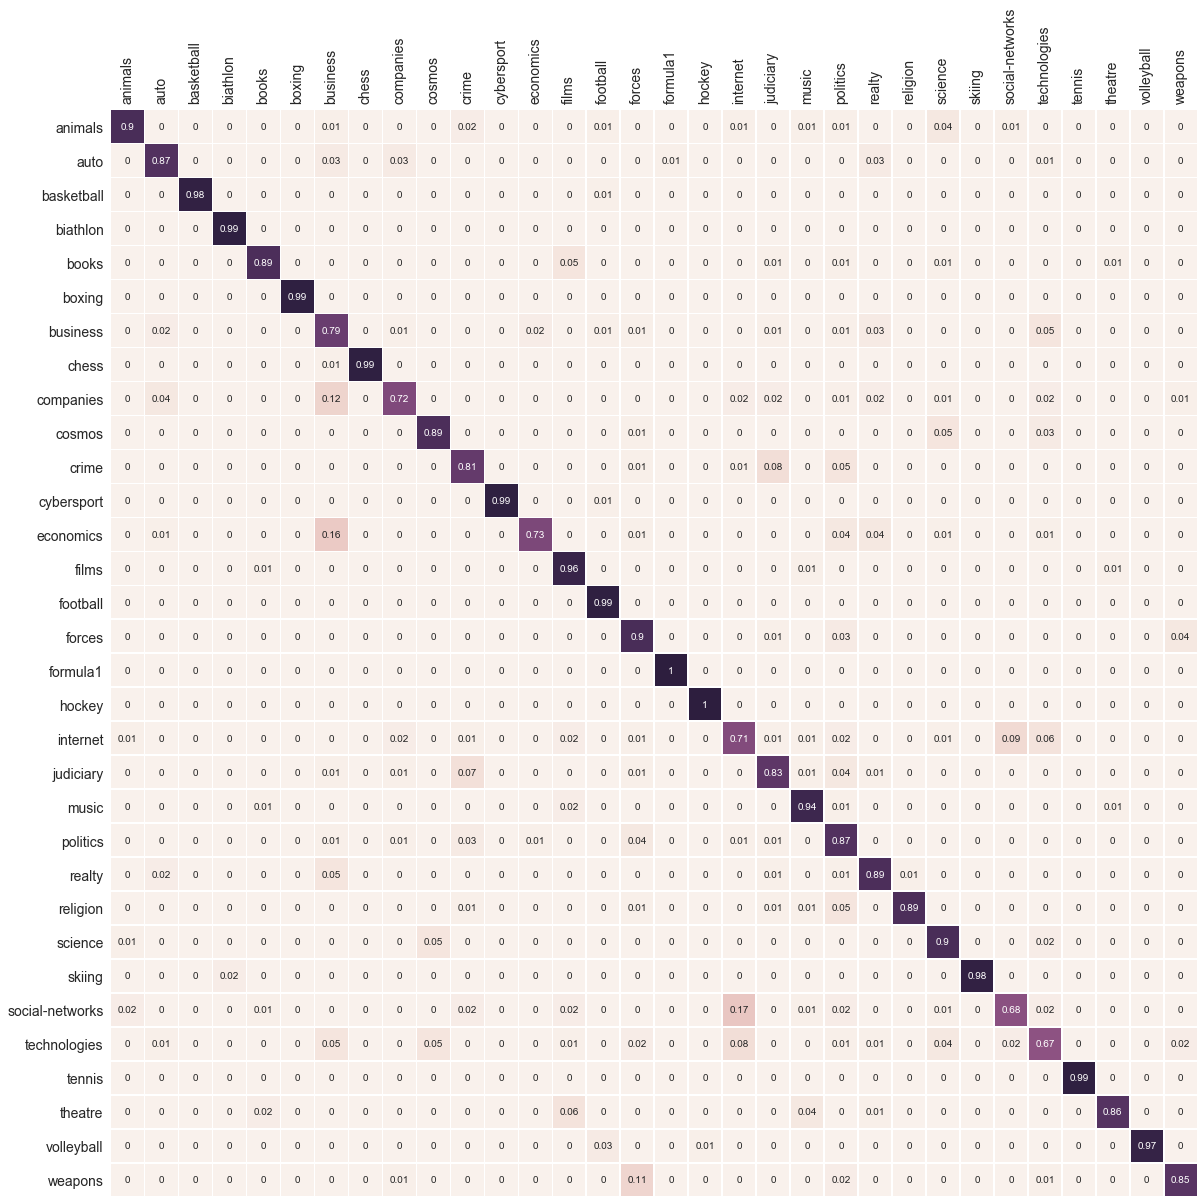

In [33]:
sns.set_context("notebook", font_scale=1.4);
plt.figure(figsize=(20, 20))
ax = sns.heatmap(df_cm, annot=True, linewidths=.5, fmt='g', cbar=False, square=True, annot_kws={"size": 10});
ax.xaxis.tick_top()
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90);

## Посмотрим на ошибки классификации

In [36]:
for i, (true, pred) in enumerate(zip(y_test, clf_prediciton)):
    if true == le.transform(['technologies'])[0] and pred == le.transform(['realty'])[0]:
        print(X_test[i][1])

http://www.vedomosti.ru/technology/news/2014/06/02/putin-poruchil-mer-proverit-informaciyu-o-peredache-pod
http://www.vedomosti.ru/technology/news/2017/03/01/679472-tesla-predstavitelstvo-rossii
http://www.vedomosti.ru/technology/articles/2014/12/09/reanimaciya-tehnoparka
http://www.vedomosti.ru/technology/articles/2012/02/15/melodiya_bez_zapisej
http://www.vedomosti.ru/technology/news/2017/03/31/683578-moskovskom
http://www.vedomosti.ru/technology/news/2016/05/24/642177-tsukerberg-podal-zayavku-o-snose-domov
http://www.vedomosti.ru/technology/news/2017/01/23/674491-magomedov-obrazovatelnii-tsentr
http://www.vedomosti.ru/technology/news/2013/02/07/v_podmoskove_sozdaetsya_socset_dlya_chinovnikov
http://www.vedomosti.ru/technology/news/2016/01/27/625654-tokio-poezdov-magnitnoi-podushke
http://www.vedomosti.ru/technology/news/2013/02/26/na_kosmodrome_vostochnyj_stroitelstvo_ostavshihsya_obektov
http://www.vedomosti.ru/technology/articles/2013/04/22/des_moines_register_facebook_postroit_no

## Выведем слова с максимальным весом внутри каждого класса

In [52]:
def print_top_K(vectorizer, clf, class_labels, k=10):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    kek = []
    cols = ['top' + str(i+1) for i in range(k)]
    for i, class_label in enumerate(class_labels):
        top_K = np.argsort(clf.coef_[i])[-k:]
        kek.append([feature_names[j] for j in top_K])
        print('%s: %s' % (class_label, ' '.join(feature_names[j] for j in top_K)))
#     return pd.DataFrame(kek, index=class_labels, columns=cols)

In [53]:
print_top_K(tfidf_vectorizer, clf, le.classes_, k=10)

animals: олень коала животный вольер слон просматривать зоопарк питомец животное кличка
auto: мобиль автокомпонент камаз авторынок автоваз автозавод осаго автопроизводитель автомобиль автопром
basketball: кливленд уникс рфб центровой евробаскет баскетбольный баскетбол баскетболист нба евролига
biathlon: фуркад касперович домрачева шипулин биатлонистка биатлон сбр ibu хохфильцен биатлонист
books: библиотека книжный писательница роман произведение книга комикс литературный поэт писатель
boxing: мейуэзер поединок лебзяк боец алоян поветкин мма бой бокс боксер
business: еврозона оао rusal мечесть читать ржд ритейлер fifa formula туроператор
chess: кирсан карлсен магнус шахматист шахматы гроссмейстер костенюк карякин фид шахматный
companies: настоящий отмечать service глава кубометр тысяча миллиард релиз процент ретейлер
cosmos: falcon небесный астронавт мкс прогресс созвездие протон светить астрофизик марс
crime: полиция педофил убивать тюремный грабитель экстремист преступник associated и

In [47]:
test_str = '''В 1969-72 годах американские астронавты установили на Луне в общей сложности шесть звездно-полосатых флагов.
С тех пор прошло много лет и утекло много лунного песка. Несмотря на отсутствие воздуха флаги за это время сильно износились.
В последний раз их видели в 2012 году, когда их снял Лунный орбитальный зонд (LRO). Тогда как минимум пять из шести флагов
находились в вертикальном положении. Однако после десятилетий, проведенных на ярком солнце, цвета, конечно же, выгорели.
По мнению ученых, сейчас флаги скорее всего почти полностью белого цвета. Все флаги стоили 5,5 долларов (32 доллара в современных ценах).
Компания AnninFlagmakers изготовила их из вискозы, волокна которой под воздействием ультрафиолетового света распадаются.
Это значит, что ткань флагов не только полностью выгорела, но и, не исключено, очень сильно обветшала. К этому следует добавить, пишет
Metro, и температурные условия: две недели ярчайшего солнца и стоградусной жары, за которыми следуют две недели лунной ночи, когда
столбик термометра, если бы он был на это рассчитан, опускался бы до отметки -150°С. НАСА менять флаги на Луне не собирается.
Агентство намерено отправлять астронавтов в далекий космос, но спутник Земли космические начальники решили облететь стороной.
В планах полет на Марс примерно в 2033 году. Последняя надежда осталась на коммерческие компании, осваивающие космос.
Не исключено, что вместо госагентства звездно-полосатые флаги на нашем спутнике заменит владелец Amazon, мультимиллардер Джефф Безос,
который мечтает о колонизации Луны.'''

In [49]:
le.inverse_transform(clf.predict(tfidf_vectorizer.transform([TEXT_PIPELINE(test_str)])))[0]

'cosmos'

In [54]:
# TODO DROP GAZETA ARMY NEWS